<a href="https://colab.research.google.com/github/boppana-tejkiran/Chat-bot/blob/main/ChatBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-27 09:30:46--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-27 09:30:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.12MB/s    in 2m 43s  

2023-01-27 09:33:30 (5.06 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import string
import matplotlib

In [ ]:
import nltk
nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
import json
data_file_path = '/content/drive/MyDrive/Intent.json'

In [ ]:
with open(data_file_path, 'r') as f:
  intents = json.load(f)

In [ ]:
inputs = []
responses = {}
tags = []

In [ ]:
for intent in intents['intents']:
  for input_pattern in intent["text"]:
    inputs.append(input_pattern)
    tags.append(intent['intent'])
  responses[intent['intent']] = intent["responses"]

In [ ]:
dataset = pd.DataFrame({'inputs': inputs, 'tags': tags})
dataset.head()
dataset.sample(frac = 1)

,inputs,tags
52,Do you know what time it is?,TimeQuery
110,I am bored gossip with me,Gossip
127,Will you open the pod bay door please,PodBayDoor
104,You are a very clever girl,Clever
116,Tell me a joke,Jokes
...,...,...
74,Comprendo,UnderstandQuery
62,That's helpful,Thanks
69,Wasn't speaking to you,NotTalking2U
112,I want to hear some gossip,Gossip


In [ ]:
dataset['inputs'] = dataset['inputs'].apply(lambda sentence: [letter.lower() for letter in sentence if letter not in string.punctuation])
dataset['inputs'] = dataset['inputs'].apply(lambda input: ''.join(input))
dataset.head(10)

,inputs,tags
0,hi,Greeting
1,hi there,Greeting
2,hola,Greeting
3,hello,Greeting
4,hello there,Greeting
5,hya,Greeting
6,hya there,Greeting
7,my user is adam,GreetingResponse
8,this is adam,GreetingResponse
9,i am adam,GreetingResponse


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [ ]:
print(labels.shape)

(143,)


In [ ]:
features = np.array(features)
labels = np.array(labels)

print(features)

[[ 0  0  0 ...  0  0 48]
 [ 0  0  0 ...  0 48 49]
 [ 0  0  0 ...  0  0 63]
 ...
 [ 0 10  1 ... 79 80 13]
 [ 0 10  1 ... 16 62 13]
 [ 0  0  0 ... 61 16 62]]


In [ ]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)

number of unique words :  117


In [ ]:
# tokenizer.word_index

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, vocab_size, embedding_size, num_classes, hidden_size):
    super().__init__()
    self.l1 = nn.Embedding(vocab_size +1 , embedding_size)
    self.l2 = nn.Conv1d(in_channels = 9, out_channels = 32, kernel_size = 5, stride = 1, padding = 0)
    self.l3 = nn.LSTM(input_size = 96, hidden_size = hidden_size, num_layers = 1, bidirectional= False, batch_first = True)
    self.l4 = nn.Linear(hidden_size, 128)
    self.l5 = nn.Linear(128, num_classes)
    self.dropout = nn.Dropout(0.2)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.l1(x)
    out = self.l2(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.l3(out)
    # print(out.shape)
    out = self.dropout((out[0][:, -1]))
    out = self.l4(out)
    out = self.relu(out)
    # print(out.shape)
    out = self.dropout(out)
    out = self.l5(out)

    return out

In [ ]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
class ChatDataset(Dataset):
  def __init__(self):
    super().__init__()
    self.n_samples = len(features)
    self.x_data = features
    self.y_data = labels

  def __getitem__(self, index):
    return (self.x_data[index], self.y_data[index])

  def __len__(self):
    return self.n_samples

In [ ]:
# hyperparameters
batch_size = 8
input_size = 117
embedding_size = 100
hidden_size = 128
output_size = 22
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = ChatDataset()
# print(dataset.x_data)
loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers= 2)

lr = 1e-5
num_epochs = 5000

In [ ]:
model = NeuralNet(117, 100, 22, hidden_size)

embedding_matrix=np.vstack(embedding_matrix).astype(np.double)
# print(torch.from_numpy(embedding_matrix).dtype)
model.l1.weight = torch.nn.Parameter(torch.from_numpy(embedding_matrix))
# model.l1.weight = model.l1.weight.to(torch.double) 
model.l1.requires_grad = False

model.double().to(device)

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
training_loss = []
for epoch in range(num_epochs):
  for (words, labels) in loader:
    words = words.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(words)
    # print("outputs:", outputs.shape, "  labels:", labels.shape)
    loss = criterian(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (epoch+1) % 50 == 0:
    print(f'epoch {epoch + 1}/{num_epochs}, loss={loss.item():.4f}')

  training_loss.append(loss.item())
  if loss.item() < 0.1:
    break

print(f'final loss, loss = {loss.item():.4f}')

epoch 50/5000, loss=3.0582
epoch 100/5000, loss=3.1088
epoch 150/5000, loss=3.0709
epoch 200/5000, loss=2.9410
epoch 250/5000, loss=2.9344
epoch 300/5000, loss=2.6593
epoch 350/5000, loss=2.7155
epoch 400/5000, loss=2.7377
epoch 450/5000, loss=2.5087
epoch 500/5000, loss=2.2597
epoch 550/5000, loss=2.0289
epoch 600/5000, loss=2.1049
epoch 650/5000, loss=1.6046
epoch 700/5000, loss=1.8965
epoch 750/5000, loss=1.5844
epoch 800/5000, loss=1.8396
epoch 850/5000, loss=1.7587
epoch 900/5000, loss=1.5995
epoch 950/5000, loss=1.7475
epoch 1000/5000, loss=1.5251
epoch 1050/5000, loss=0.9966
epoch 1100/5000, loss=0.9901
epoch 1150/5000, loss=0.9137
epoch 1200/5000, loss=0.9564
epoch 1250/5000, loss=0.9764
epoch 1300/5000, loss=0.5605
epoch 1350/5000, loss=1.1838
epoch 1400/5000, loss=0.8018
epoch 1450/5000, loss=0.8709
epoch 1500/5000, loss=0.3644
epoch 1550/5000, loss=0.4847
epoch 1600/5000, loss=1.3663
epoch 1650/5000, loss=0.7414
epoch 1700/5000, loss=0.6184
epoch 1750/5000, loss=0.6659
epoch

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

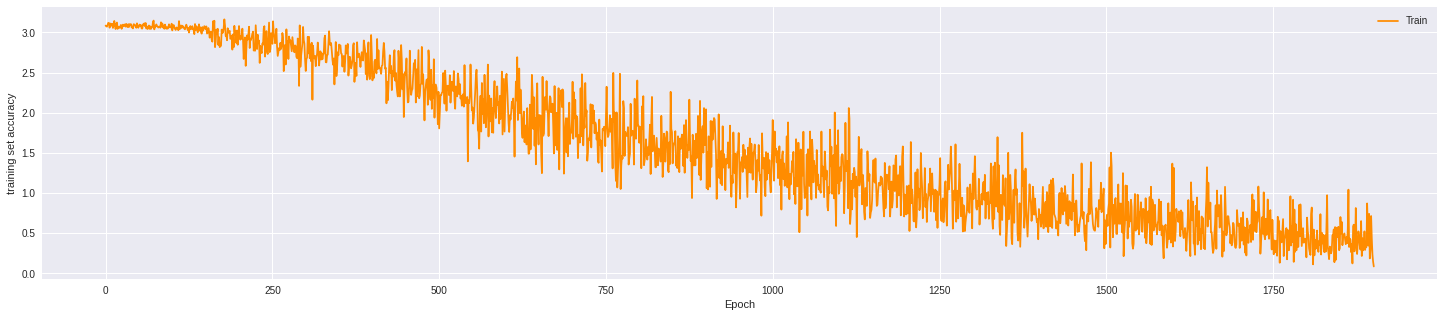

In [ ]:
draw_plot(training_loss,'training set accuracy' )

In [ ]:
data = {
    "model_state" : model.state_dict(),
    "input_size" : input_size,
    "embedding_size" : embedding_size,
    "hidden_size" : hidden_size,
    "output_size" : output_size,
    "responses" : responses
}

FILE = "/content/drive/MyDrive/data.pth"
torch.save(data, FILE)
print(f'training complete. File saved to {FILE}')

training complete. File saved to /content/drive/MyDrive/data.pth


In [ ]:
import random

In [ ]:
with open(data_file_path, 'r') as f:
  intents = json.load(f)

data = torch.load(FILE)
input_size = data['input_size']
hidden_size = data['hidden_size']
embedding_size = data['embedding_size']
output_size = data['output_size']
responses = data['responses']
model_state = data['model_state']
            
model = NeuralNet(input_size, embedding_size, output_size, hidden_size).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNet(
  (l1): Embedding(118, 100)
  (l2): Conv1d(9, 32, kernel_size=(5,), stride=(1,))
  (l3): LSTM(96, 128, batch_first=True)
  (l4): Linear(in_features=128, out_features=128, bias=True)
  (l5): Linear(in_features=128, out_features=22, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [ ]:
bot_name = "Chat Bot"
print("Lets chat! type 'quit' to exit")
while True:
  sentence = input('You: ')
  if sentence == "quit":
    break

  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],9)
  pred_input = torch.from_numpy(pred_input).to(device)

  # sentence = tokenize(sentence)
  # X = bag_of_words(sentence, all_words)
  # X = X.reshape(1, X.shape[0])
  # X = torch.from_numpy(X)

  output = model(pred_input).to(device)
  _, predicted = torch.max(output, dim = 1)
  tag = tags[predicted.item()]

  probs = torch.softmax(output, dim =1)
  # print(probs, predicted.item())
  prob = probs[0][predicted.item()]

  if prob.item() > 0.51:
    response_tag = le.inverse_transform([predicted.item()])[0]
    print(f"{bot_name}: {random.choice(responses[response_tag])}")
  else:
    print(f"{bot_name}: I do not understand...")

Lets chat! type 'quit' to exit
You: hi
Chat Bot: Hi human, please tell me your GeniSys user
You: how are you
Chat Bot: Hello, how are you? I am great thanks! Please tell me your GeniSys user
You: tell me a joke
Chat Bot: A restaurant nearby had a sign in the window which said 'We serve breakfast at any time', so I ordered French toast in the Renaissance.
You: what is your name
Chat Bot: I do not understand...
You: tell me your name
Chat Bot: Your name is <HUMAN>, how can I help you?
You: what is your name
Chat Bot: I do not understand...
You: tell me my name
Chat Bot: They call you <HUMAN>, what can I do for you?
You: quit
